In [1]:
import os

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def cal_time(path):
    s = ['program start time = ',  # 0
    'train start time = ',  # 1
    'train done time = ',  # 2
    'val identity done time = ',  # 3
    'val verify done time = ',  # 4
    'test start time = ',  # 5
    'test identity done time = ',  # 6
    'test verify done time = ']  # 7

    program_start = 0
    train_start = []
    val_identity_start = []  # train_done
    val_verify_start = []  # val_identity_done
    val_done = []  # val_verify_done
    test_identity_start = 0
    test_verify_start = 0  # test_identity_done
    program_done = 0  # test_verify_done

    file = open(path, 'r')
    for line in file:
        line = line.rstrip('\n')
        if line.find(s[0]) != -1:
            program_start = datetime.datetime.strptime(line[line.find(s[0]) + len(s[0]):], '%Y-%m-%d %H:%M:%S.%f')
        elif line.find(s[1]) != -1:
            train_start.append(datetime.datetime.strptime(line[line.find(s[1]) + len(s[1]):], '%Y-%m-%d %H:%M:%S.%f'))
        elif line.find(s[2]) != -1:
            val_identity_start.append(datetime.datetime.strptime(line[line.find(s[2]) + len(s[2]):], '%Y-%m-%d %H:%M:%S.%f'))
        elif line.find(s[3]) != -1:
            val_verify_start.append(datetime.datetime.strptime(line[line.find(s[3]) + len(s[3]):], '%Y-%m-%d %H:%M:%S.%f'))
        elif line.find(s[4]) != -1:
            val_done.append(datetime.datetime.strptime(line[line.find(s[4]) + len(s[4]):], '%Y-%m-%d %H:%M:%S.%f'))
        elif line.find(s[5]) != -1:
            test_identity_start = datetime.datetime.strptime(line[line.find(s[5]) + len(s[5]):], '%Y-%m-%d %H:%M:%S.%f')
        elif line.find(s[6]) != -1:
            test_verify_start = datetime.datetime.strptime(line[line.find(s[6]) + len(s[6]):], '%Y-%m-%d %H:%M:%S.%f')
        elif line.find(s[7]) != -1:
            program_done = datetime.datetime.strptime(line[line.find(s[7]) + len(s[7]):], '%Y-%m-%d %H:%M:%S.%f')

    train_start = np.array(train_start)
    val_identity_start = np.array(val_identity_start)
    val_verify_start = np.array(val_verify_start)
    val_done = np.array(val_done)

    time = {'total time': (program_done - program_start).total_seconds(),
            'avg train time': np.mean(val_identity_start - train_start).total_seconds(),
            'avg val identity time': np.mean(val_verify_start - val_identity_start).total_seconds(),
            'avg val verify time': np.mean(val_done - val_verify_start).total_seconds(),
            'test identity time': (test_verify_start - test_identity_start).total_seconds(),
            'test verify time': (program_done - test_verify_start).total_seconds(),}
    return time

In [4]:
path = '../log/cat/q/CASIA_k=1_lbp_size=3000_q=100_t=100_e=0.010000_mu=1.000000_tp=0.800000_tn=0.100000_lambda=0.010000_knn=1.log'
cal_time(path)

{'total time': 701.910145,
 'avg train time': 139.886875,
 'avg val identity time': 0.06055,
 'avg val verify time': 0.33945,
 'test identity time': 0.097922,
 'test verify time': 0.37216}

In [3]:
def cal_acc(path):
    s = ['test identity acc: ', 'test verify acc: ']

    identity = 0
    verify = 0

    file = open(path, 'r')
    for line in file:
        line = line.rstrip('\n')
        if line.find(s[0]) != -1:
            identity = line[line.find(s[0]) + len(s[0]):]
        elif line.find(s[1]) != -1:
            verify = line[line.find(s[1]) + len(s[1]):]
    
    acc = {'identity': identity, 'verify': verify}
    return acc

In [40]:
time = []

path = '../log/'
log_dir = os.listdir(path)
log_dir.sort()
for method_dir in log_dir:
    if method_dir == '.DS_Store':
        continue
    for file in os.listdir(path + method_dir):
        if file.split('.')[-1] != 'log':  # 排除 .DS_Store 和文件夹
            continue
        tmp = cal_time(path + method_dir + '/' + file)
        acc = cal_acc(path + method_dir + '/' + file)
        tmp['method'] = method_dir
        tmp['dataset'] = file.split('_')[0]
        tmp['view num'] = file.split('_')[1]
        tmp['identity'] = float(acc['identity'])
        tmp['verify'] = float(acc['verify'])
        time.append(tmp)

df = pd.DataFrame(time, columns=['method', 'dataset', 'view num', 
                                 'total time', 'avg train time',  'avg val identity time', 'avg val verify time', 'test identity time', 'test verify time', 
                                 'identity', 'verify'])
new_line = pd.DataFrame(df[(df['method'] == 'sum') & (df['view num'] == 'k=1')])  # 单视图 reg 和 sum 的结果相同
new_line['method'] = 'reg'
df = pd.concat([df, new_line], ignore_index=True)
df.loc[df['method'] == 'sum', 'method'] = '0 MvSL'  # 将 sum、cat、reg 重命名并按照论文中出现的先后顺序排序
df.loc[df['method'] == 'cat', 'method'] = '1 MvSL_SC'
df.loc[df['method'] == 'reg', 'method'] = '2 MvSL_CV'
df['view num'] = df['view num'].str.upper()  # 将横坐标的 k=1 变更为 K=1
df = df.sort_values(['method', 'dataset', 'view num'], ascending=[True, True, True])  # 排序
df = df.groupby(['method', 'dataset', 'view num'])[[
    'total time', 'avg train time', 'avg val identity time', 'avg val verify time', 'test identity time', 'test verify time', 
    'identity', 'verify']].mean().reset_index()
# df.to_csv('../result/time.csv', index=False)
df

,method,dataset,view num,total time,avg train time,avg val identity time,avg val verify time,test identity time,test verify time,identity,verify
0,0 MvSL,CASIA,K=1,973.244055,164.392450,23.988716,0.202709,30.015787,0.301855,0.914850,0.934000
1,0 MvSL,CASIA,K=2,1001.780442,168.065455,25.617249,0.202891,32.013754,0.332781,0.971541,0.955667
2,0 MvSL,CASIA,K=3,997.303186,166.539309,26.076495,0.201847,32.865110,0.343613,0.985468,0.966000
3,0 MvSL,CASIA,K=4,1020.988333,171.129237,26.262826,0.204851,32.637604,0.359345,0.990917,0.968000
4,0 MvSL,tongji,K=1,1523.017585,162.930808,112.989921,0.214562,141.994751,0.338164,0.978646,0.935000
5,0 MvSL,tongji,K=2,1601.079964,168.177118,121.333723,0.219699,152.029494,0.388733,0.997014,0.966000
6,0 MvSL,tongji,K=3,1622.131333,168.145304,124.276488,0.215994,158.488590,0.444785,0.995833,0.970000
7,0 MvSL,tongji,K=4,1665.837956,172.101342,128.181700,0.240660,162.629879,0.579160,1.000000,0.986000
8,1 MvSL_SC,CASIA,K=1,576.063487,114.737453,0.058833,0.323297,0.088842,0.360471,0.916667,0.947000
9,1 MvSL_SC,CASIA,K=2,725.313393,144.580146,0.059471,0.323371,0.112885,0.379616,0.975931,0.962667


In [76]:
def draw(df, dataset):
    COLORS = ['#2878B5', '#B52828', '#28B584']  # 饱和度 78%, 亮度 71%
    HATCH = ['', '/', '.']
    MARKER = ['', 'x', '.']

    df_tmp = df[df['dataset'] == dataset]
    methods = df_tmp['method'].unique()
    view_nums = df_tmp['view num'].unique()
    bar_width = 0.1
    index = range(len(view_nums))
    index = [x - bar_width for x in index]  # 为了让横坐标出现在三个柱子中间

    fig, ax1 = plt.subplots()
    for i in range(len(methods)):
        data = df_tmp[df_tmp['method'] == methods[i]]
        ax1.bar(index, data['total time'], bar_width, hatch=HATCH[i]*3, edgecolor=COLORS[i], color='#FFFFFF', label=methods[i].split(' ')[1] + ' time')
        index = [x + bar_width for x in index]

    ax2 = ax1.twinx()
    for i in range(len(methods)):
        data = df_tmp[df_tmp['method'] == methods[i]]
        ax2.plot(data['view num'], data['identity'], marker=MARKER[i], color=COLORS[i], label=methods[i].split(' ')[1] + ' identity acc')
        ax2.plot(data['view num'], data['verify'], linestyle='--', marker=MARKER[i], color=COLORS[i], label=methods[i].split(' ')[1] + ' verify acc')

    ax1.set_ylabel('Total Time')
    ax1.set_xlabel('View Num')
    ax2.set_ylabel('Accuracy')
    fig.legend(bbox_to_anchor=(1, 0.52), loc='upper left')
    plt.show()

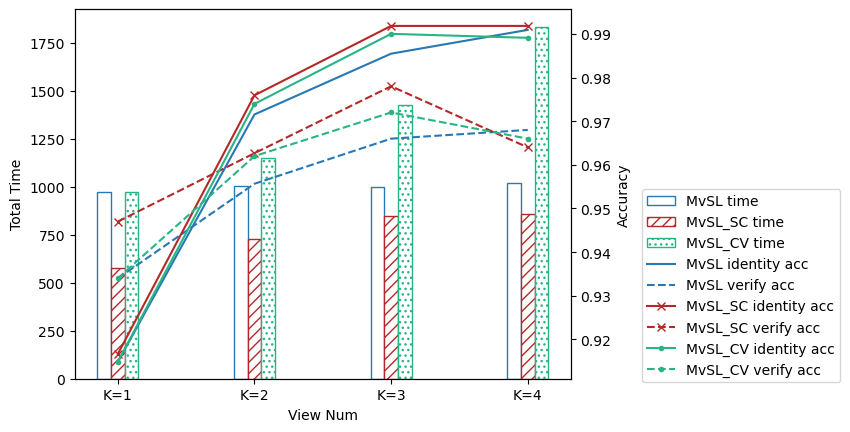

In [77]:
draw(df, 'CASIA')

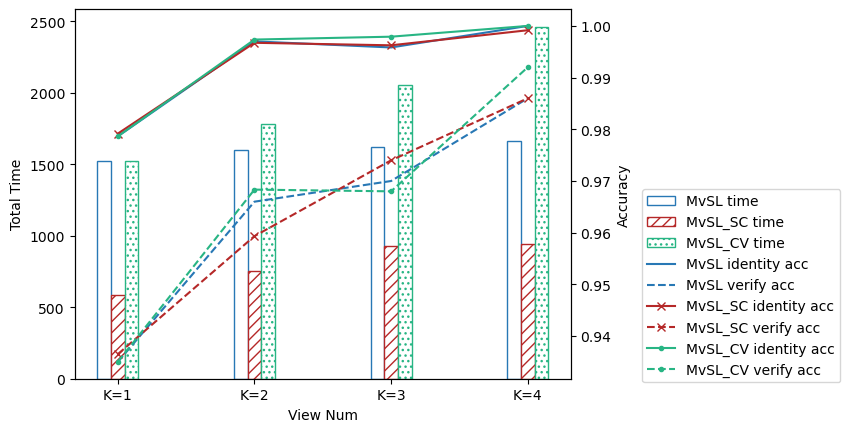

In [78]:
draw(df, 'tongji')